In [3]:
# Load jld files and analyze

import h5py
import numpy as np
import matplotlib.pyplot as plt

In [12]:
survive_data = h5py.File("survive_data_5.jld2", "r")
survive_data = survive_data['data'][:]
survive_data = survive_data/100.0

In [17]:
avg_suvive_data = np.mean(survive_data, axis=0)

survive_data_std = np.std(survive_data,axis=0)

(0.0, 1.0)

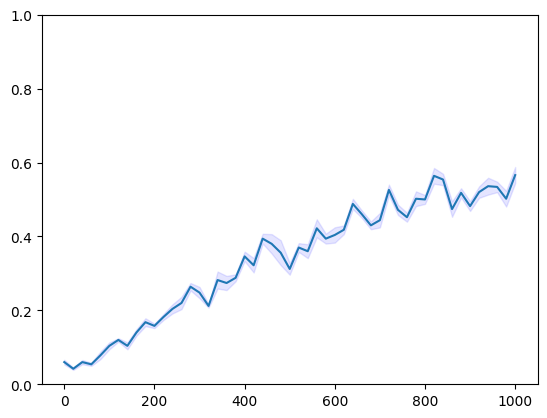

In [37]:
x_data = list(np.arange(51)*20)
conf_int = 1.96*np.std(survive_data,axis=0)/np.sqrt(len(x_data))
plt.plot(x_data,avg_suvive_data, )
plt.fill_between(x_data,(avg_suvive_data-conf_int),(avg_suvive_data+conf_int),color='b',alpha=.1)
# plt.plot(x_data,avg_suvive_data+survive_data_std,'--','r')
plt.ylim(0,1)

In [34]:
action_history = h5py.File("action_histories_6.jld2","r")
action_history = action_history['data'][:,0,50]

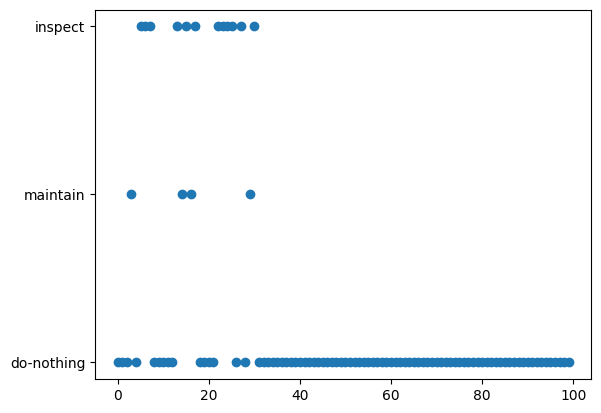

In [35]:
time = np.arange(0,100)
plt.scatter(time,action_history)